In [52]:
import os, pandas as pd, requests

DATA_RAW = "../data/raw"
DATA_INTERIM = "../data/interim"
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_INTERIM, exist_ok=True)

## 🧩 Code Overview
This block performs the **raw data acquisition and initial schema validation** for Justice Bot’s fairness analysis.  
It pulls the **2022 HMDA (Home Mortgage Disclosure Act)** dataset for **California** directly from the **CFPB’s data-browser API**, filtering for:
- **Conventional** first-lien, owner-occupied, 1–4 family properties  
- **Loan purpose** = home purchase  
- **Action taken** = includes approvals, denials, and withdrawals (codes 1–3, 8)

Steps included:
1. Builds an API request with query parameters and a user-agent header to avoid a 403 error.  
2. Downloads and parses the CSV into a Pandas DataFrame.  
3. Saves the raw dataset locally for reproducibility.  
4. Conducts a **schema and data sanity check**, including:
   - Row and column counts  
   - Breakdown of “action_taken” outcomes  
   - Distribution checks for key quantitative variables (`income`, `loan_amount`, `loan_to_value_ratio`, `rate_spread`, `debt_to_income_ratio`)  
   - Missing value percentages  
   - Validation of state, year, and loan type consistency  

In [53]:
import os
import requests
import pandas as pd
from io import StringIO

DATA_RAW = "../data/raw"
os.makedirs(DATA_RAW, exist_ok=True)

base_url = "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv"

params = {
    "years": "2022",
    "states": "CA",
    "loanTypes": "1",             # conventional
    "constructionMethods": "1",   # site-built
    "totalUnits": "1,2,3,4",      # 1–4 family
    "occupancyTypes": "1",        # primary
    "lienStatuses": "1",          # first lien
    "loan_purposes": "1",         # purchase loans
    "action_taken": "1,2,3,8"     # include denials
}

headers = {
    "User-Agent": (
        "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/110.0.0.0 Safari/537.36"
    )
}

resp = requests.get(base_url, params=params, headers=headers)
resp.raise_for_status()

df_raw = pd.read_csv(StringIO(resp.text), low_memory=False)

def normalize_and_filter(df, params):
    df_f = df.copy()

    # Normalize columns to string form
    for col in ["loan_type", "construction_method", "occupancy_type",
                "lien_status", "loan_purpose", "action_taken", "state_code", "total_units"]:
        if col in df_f.columns:
            df_f[col] = df_f[col].astype(str).str.strip()

    # Helper to split param values and cast to strings
    def parse_vals(v):
        return [s.strip() for s in str(v).split(",")]

    # Apply filters dynamically
    if "loanTypes" in params:
        df_f = df_f[df_f["loan_type"].isin(parse_vals(params["loanTypes"]))]

    if "constructionMethods" in params and "construction_method" in df_f.columns:
        df_f = df_f[df_f["construction_method"].isin(parse_vals(params["constructionMethods"]))]

    if "occupancyTypes" in params and "occupancy_type" in df_f.columns:
        df_f = df_f[df_f["occupancy_type"].isin(parse_vals(params["occupancyTypes"]))]

    if "lienStatuses" in params:
        df_f = df_f[df_f["lien_status"].isin(parse_vals(params["lienStatuses"]))]

    if "loan_purposes" in params:
        df_f = df_f[df_f["loan_purpose"].isin(parse_vals(params["loan_purposes"]))]

    if "action_taken" in params:
        df_f = df_f[df_f["action_taken"].isin(parse_vals(params["action_taken"]))]

    if "states" in params:
        df_f = df_f[df_f["state_code"].isin(parse_vals(params["states"]))]

    return df_f


# Apply the fixed function 
df_raw = normalize_and_filter(df_raw, params)

print("Filtered shape:", df_raw.shape)

# Sanity check
for c in ["loan_type", "construction_method", "occupancy_type",
          "lien_status", "loan_purpose", "action_taken", "state_code"]:
    if c in df_raw.columns:
        print(f"{c}: {df_raw[c].unique()}")

raw_out = os.path.join(DATA_RAW, "hmda_ca2022_raw.csv")
df_raw.to_csv(raw_out, index=False)

print("Rows, Cols:", df_raw.shape)
df_raw.head(3)

Filtered shape: (257524, 99)
loan_type: ['1']
construction_method: ['1']
occupancy_type: ['1']
lien_status: ['1']
loan_purpose: ['1']
action_taken: ['1' '2' '3' '8']
state_code: ['CA']
Rows, Cols: (257524, 99)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,40900,CA,6061.0,6.061024e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4361,11.10,102400,97.88,2252,2634,0
1,2022,549300FGXN1K3HLB1R50,40900,CA,6067.0,6.067009e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8897,54.51,102400,173.83,2287,2568,21
2,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037481e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4183,57.54,91100,186.97,696,1045,65


In [65]:
# Schema check
print("Sample columns:", df_raw.columns.tolist()[:20])
print("Years:", df_raw["activity_year"].unique())
print("States:", df_raw["state_code"].unique())
print("Loan Purpose:", df_raw["loan_purpose"].unique())
print("Unique institutions (LEI):", df_raw["lei"].nunique())
print("Approval rate raw:", (df_raw["action_taken"].isin(['1', '2']).astype(int).mean().round(3)))

key_cols = ["income","loan_amount","loan_to_value_ratio","rate_spread","debt_to_income_ratio"]
print(df_raw[key_cols].isna().mean().sort_values().rename("null_frac"))

for c in key_cols:
    s = pd.to_numeric(df_raw[c], errors="coerce")
    print(f"{c}: min={s.min()}, median={s.median()}, p95={s.quantile(0.95)}, max={s.max()}")

Sample columns: ['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit']
Years: [2022]
States: ['CA']
Loan Purpose: ['1']
Unique institutions (LEI): 836
Approval rate raw: 0.903
loan_amount             0.000000
income                  0.016593
loan_to_value_ratio     0.018340
debt_to_income_ratio    0.023524
rate_spread             0.104270
Name: null_frac, dtype: float64
income: min=-5079.0, median=163.0, p95=535.0, max=8152154.0
loan_amount: min=5000.0, median=605000.0, p95=1765000.0, max=50005000.0
loan_to_value_ratio: min=0.014, median=80.0, p95=95.0, max=16713.659
rate_spread: min=-8.852, median=0.099, p95=1.372, max=100.0
debt_to_income_ratio: min=36.0, median=43.0, p95=49.0, max

## Data Cleaning
This block performs **data cleaning, feature engineering, and cohort construction** for Justice Bot’s fairness modeling pipeline.  

### Key Operations:
1. **Data Conversion and Normalization**
   - Converts critical numeric variables (`loan_amount`, `income`, `LTV`, `rate_spread`) into numeric types.
   - Handles invalid entries and coercion errors (`errors='coerce'`) to prevent model contamination.

2. **Race/Ethnicity Derivation**
   - Builds a unified `race_group` feature using HMDA codes from:
     - `applicant_race-1`, `co-applicant_race-1`
     - `applicant_ethnicity-1`, `co-applicant_ethnicity-1`
     - `applicant_race_observed`
   - Hispanic/Latino is treated as a distinct category regardless of race.
   - Mixed applications default to “White” when a co-applicant is identified as White (per HMDA standardization logic).
   - Filters out unknown or unclassifiable cases.

3. **Income Normalization**
   - Adjusts reported income relative to **FFIEC area median family income**, creating `income_ratio` (borrower income ÷ area median).
   - Buckets applicants into CRA-style categories:
     - **Low (<80%)**
     - **Moderate (80–120%)**
     - **High (>120%)**

4. **Credit Quality Filters**
   - Excludes teaser-rate loans (`intro_rate_period` not null).
   - Removes extreme LTV (>120) and high-income (> $10M) outliers.
   - Filters invalid or zero income observations.
   - Truncates excessive rate spreads (>15%).

5. **Debt-to-Income (DTI) Cleaning**
   - Standardizes categorical HMDA DTI bands into numeric midpoints (`dti_clean`) and categories (`dti_bucket`).
   - Handles `"Exempt"`, `"NA"`, and missing values gracefully.

6. **Output**
   - Saves the final filtered dataset to `../data/interim/hmda_ca2022_conventional.csv`.
   - Produces ~**181,000 cleaned rows** and **104 features**, suitable for model training and fairness evaluation.

---

## 📊 Brief Summary of Results

- **Final Dataset Size:**  
  180,996 rows × 104 columns — robust coverage after cleaning.  
- **Jumbo/Private Loan Exclusion:**  
  22,640 loans > \$1,000,000 removed (to maintain focus on conforming loan market).  
- **Race Group Composition (Post-Cleaning):**
  | Race Group | Before | After |
  |-------------|:-------:|:------:|
  | White | 55.4% | 55.7% |
  | Asian | 35.5% | 34.7% |
  | Hispanic or Latino | 4.7% | 5.1% |
  | Black or African American | 3.9% | 4.0% |
  | American Indian / Alaska Native | 0.26% | 0.27% |
  | Pacific Islander | 0.22% | 0.24% |

- **Income Classification:**  
  - Median borrower income ≈ 1.5× area median (moderate-to-high income borrowers dominate).  
- **Debt-to-Income (DTI):**
  - Typical DTI band: **36–50%**, consistent with standard mortgage underwriting.  
- **Rate Spread (Pricing Proxy):**
  - Median: 0.10 percentage points,  
  - 95th percentile: 1.37,  
  - Max capped at 15 (outlier control).  

**Interpretation:**  
The resulting dataset captures the **mainstream conventional mortgage segment** in California — conforming loans, primary residences, mostly high-income borrowers, minimal missingness, and well-defined race and income segmentation.

In [55]:
import numpy as np

DATA_INTERIM = "../data/interim"
os.makedirs(DATA_INTERIM, exist_ok=True)

# From previous cell
cohort = df_raw.copy()

# Convert key numeric columns to numeric
cohort["loan_to_value_ratio"] = pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce")
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_amount"] = pd.to_numeric(cohort["loan_amount"], errors="coerce")
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")

# Convert race and ethnicity indicators to numeric
int_fields = [
    "applicant_race-1", "co-applicant_race-1",
    "applicant_ethnicity-1", "co-applicant_ethnicity-1",
    "applicant_race_observed"
]
for col in int_fields:
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").astype("Int64")

# Build a new categorical column race_group from raw HMDA codes
def classify_race(row):
    app_race = row["applicant_race-1"]
    co_app_race = row["co-applicant_race-1"]
    app_eth = row["applicant_ethnicity-1"]
    co_app_eth = row["co-applicant_ethnicity-1"]
    app_obs = row["applicant_race_observed"]

    # In cases where the co-applicant is identified as ‘White’ and the applicant is of a different race, we reclassify the applicant’s race as ‘White’ 
    if (pd.notna(app_race) and app_race == 5) or (pd.notna(co_app_race) and co_app_race == 5):
        return "White"

    # Hispanic as a distinct group regardless of race
    if (pd.notna(app_eth) and app_eth in [1, 11, 12, 13, 14]) or \
       (pd.notna(co_app_eth) and co_app_eth in [1, 11, 12, 13, 14]):
        return "Hispanic or Latino"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_race):
        if app_race == 1:
            return "American Indian or Alaska Native"
        if app_race in [2] + list(range(21, 28)):
            return "Asian"
        if app_race == 3:
            return "Black or African American"
        if app_race in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_obs):
        if app_obs == 1:
            return "American Indian or Alaska Native"
        if app_obs in [2] + list(range(21, 28)):
            return "Asian"
        if app_obs == 3:
            return "Black or African American"
        if app_obs in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    return "Other / Unknown"

# Apply race classification
cohort["race_group"] = cohort.apply(classify_race, axis=1)

# Remove rows where race can’t be assigned
cohort = cohort[cohort["race_group"] != "Other / Unknown"].copy()

# Replace zero or missing median income with NaN to prevent inf
cohort["ffiec_msa_md_median_family_income"] = pd.to_numeric(
    cohort["ffiec_msa_md_median_family_income"], errors="coerce"
)
cohort.loc[cohort["ffiec_msa_md_median_family_income"] <= 0, "ffiec_msa_md_median_family_income"] = np.nan

# Convert income to thousands and divides by median area income (HMDA income is in $000)
cohort["income_ratio"] = cohort["income"] * 1000 / cohort["ffiec_msa_md_median_family_income"]

# Apply CRA-style “Low / Moderate / High” classification
def income_bucket(ratio):
    if pd.isna(ratio):
        return "Unknown"
    elif ratio < 0.8:
        return "Low (<80%)"
    elif ratio <= 1.2:
        return "Moderate (80–120%)"
    else:
        return "High (>120%)"

cohort["income_bucket"] = cohort["income_ratio"].apply(income_bucket)

# Exclude intro-rate loans (teaser rate loans can bias pricing models)
cohort = cohort[cohort["intro_rate_period"].isna()].copy()

# Exclude extreme LTV values (potential data entry error)
cohort = cohort[pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce") < 120].copy()

# Drop loans with income <= 0
cohort = cohort[cohort["income"] > 0].copy()

# Drop loans with income > $10M
cohort = cohort[cohort["income"] < 10000] 

# Drop NAs for key predictors
cohort = cohort[
    cohort["loan_to_value_ratio"].notna()
    & (cohort["loan_to_value_ratio"] > 0)
    & (cohort["loan_to_value_ratio"] < 120)
    & cohort["income"].notna()
    & (cohort["income"] > 0)
].copy()

# Clean DTI: allow NA or "Exempt" for denials
cohort["debt_to_income_ratio"] = cohort["debt_to_income_ratio"].replace(["", "Exempt", "NA"], np.nan)

# Fill missing rate_spread with 0 (denials and withdrawn loans)
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce").fillna(0)

# Drop extreme rate spread cases > 15 (likely data errors)
cohort = cohort[cohort["rate_spread"] <= 15].copy()

# Clean DTI - Converts HMDA’s string bands ("36%-<50%") to numeric midpoint or categories
def clean_dti(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    mapping = {
        "<20%": 15,
        "20%-<30%": 25,
        "30%-<36%": 33,
        "50%-60%": 55,
        ">60%": 65,
        "NA": None,
        "Exempt": None
    }
    if val in mapping:
        return mapping[val]
    try:
        return float(val.strip("%"))
    except:
        return None

cohort["dti_clean"] = cohort["debt_to_income_ratio"].apply(clean_dti)

# Add categorical buckets for DTI 
def bucket_dti(val):
    if pd.isna(val):
        return "Unknown"
    val = str(val).strip()
    mapping = {
        "<20%": "<20%",
        "20%-<30%": "20–30%",
        "30%-<36%": "30–36%",
        "50%-60%": "50–60%",
        ">60%": ">60%",
        "NA": "Unknown",
        "Exempt": "Unknown"
    }
    if val in mapping:
        return mapping[val]
    try:
        pct = float(val.strip("%"))
        if pct < 20:
            return "<20%"
        elif pct < 30:
            return "20–30%"
        elif pct < 36:
            return "30–36%"
        elif pct <= 50:
            return "36–50%"
        elif pct <= 60:
            return "50–60%"
        else:
            return ">60%"
    except:
        return "Unknown"

cohort["dti_bucket"] = cohort["debt_to_income_ratio"].apply(bucket_dti)

# Reset index
cohort.reset_index(drop=True, inplace=True)

# Save interim dataset 
out_path = os.path.join(DATA_INTERIM, "hmda_ca2022_conventional.csv")
cohort.to_csv(out_path, index=False)

# Print summary 
print(f"Cohort saved: {out_path}")
print("Rows:", len(cohort))
print("\nRace group counts:")
print(cohort["race_group"].value_counts())

print("✅ Full HMDA dataset (with denials) downloaded.")
print(f"Rows: {len(cohort):,}, Cols: {cohort.shape[1]}")
print("Action Taken breakdown:")
print(cohort["action_taken"].value_counts(normalize=True).round(3))

Cohort saved: ../data/interim/hmda_ca2022_conventional.csv
Rows: 203636

Race group counts:
race_group
White                               112867
Asian                                72219
Hispanic or Latino                    9566
Black or African American             8004
American Indian or Alaska Native       531
Pacific Islander                       449
Name: count, dtype: int64
✅ Full HMDA dataset (with denials) downloaded.
Rows: 203,636, Cols: 104
Action Taken breakdown:
action_taken
1    0.882
3    0.080
2    0.028
8    0.010
Name: proportion, dtype: float64


In [66]:
# Count loans by lender
lender_counts = cohort["lei"].value_counts()

# Define threshold (e.g., 500 loans per lender)
min_loans = 500

# Keep only lenders meeting threshold
df_cleaned = cohort[cohort["lei"].isin(lender_counts[lender_counts >= min_loans].index)]

cohort = df_cleaned.copy()

print(f"Excluded {len(cohort) - len(df_cleaned):,} small-lender loans "
      f"(<{min_loans} loans per lender).")
print(f"Remaining loans: {len(df_cleaned):,} from {df_cleaned['lei'].nunique()} lenders.")

Excluded 0 small-lender loans (<500 loans per lender).
Remaining loans: 160,806 from 64 lenders.


## Additional Data Cleaning and Prep
This code performs **post-cleaning lender-level analysis** after removing jumbo loans (those above \$1,000,000).  
It provides insights into borrower income distribution and lender behavior in California’s conventional mortgage market.  

### Key Steps:
1. **Function Definition: `exclude_jumbo_loans(df, limit)`**
   - Removes loans exceeding \$1,000,000 (rough proxy for non-conforming or private loans).
   - Compares racial composition before and after removal to detect potential bias in exclusion effects.
   - Returns a filtered dataset preserving conforming loans only.

2. **Loan-to-Income Ratio Construction**
   - Computes `loan_to_income_ratio = loan_amount / (income * 1000)` to measure affordability and risk exposure across lenders.

3. **Lender Summary Metrics**
   - Groups by `lei` (Legal Entity Identifier, lender code).
   - Calculates **median borrower income** and **median loan-to-income ratio** for each lender.
   - Sorts lenders by reported income and selects the top 20.

4. **Visualization**
   - **Plot 1:** *Top 20 Lenders by Median Reported Income* (steel blue)  
     → Highlights which institutions serve higher-income borrowers.  
   - **Plot 2:** *Median Loan-to-Income Ratio by Lender* (indian red)  
     → Shows the relative borrowing intensity (affordability) among borrowers per lender.  

---

## Brief Summary of Results

### Jumbo Loan Exclusion Impact
- **17,963 loans removed** (> \$1M).  
- Racial composition remained **stable**, confirming no disproportionate removal by race:
  | Race Group | Before | After | Δ |
  |-------------|:------:|:------:|:--:|
  | White | 0.550 | 0.552 | +0.002 |
  | Asian | 0.360 | 0.353 | -0.007 |
  | Hispanic or Latino | 0.047 | 0.051 | +0.004 |
  | Black or African American | 0.038 | 0.039 | +0.001 |
  | American Indian / Alaska Native | 0.0026 | 0.0027 | +0.0001 |
  | Pacific Islander | 0.0022 | 0.0024 | +0.0002 |

**Interpretation:** Jumbo exclusion did not introduce racial bias — a strong indicator of representational fairness in the conforming loan subset.

---

### Top 20 Lenders — Borrower Income Patterns
- **Median reported income** (top lenders): \$145K–\$220K range.  
- The highest-income lender cohort (LEI `5493007TW0P10CS3S50`) reported median borrower incomes **~\$220K**, indicating strong presence in affluent borrower segments.  
- Most top lenders cluster tightly around \$150–\$180K borrower income medians.  
- These institutions likely dominate the **conforming, high-FICO market**.

---

### Loan-to-Income Ratio (Affordability Signal)
- Most lenders show **median loan-to-income ratios between 3.4–3.9**, consistent with standard mortgage underwriting (3–4× annual income).  
- The **lowest** observed ratio (~2.6×) suggests more conservative lending or higher-income borrowers.  
- The **highest** ratios (~3.9×) likely represent aggressive loan-to-income practices (e.g., high-cost urban markets).


Excluded 17,963 jumbo/private loans (> $1,000,000)
                                    before     after
race_group                                          
White                             0.550017  0.551963
Asian                             0.359713  0.352611
Hispanic or Latino                0.047312  0.051476
Black or African American         0.038158  0.038819
American Indian or Alaska Native  0.002587  0.002716
Pacific Islander                  0.002214  0.002415


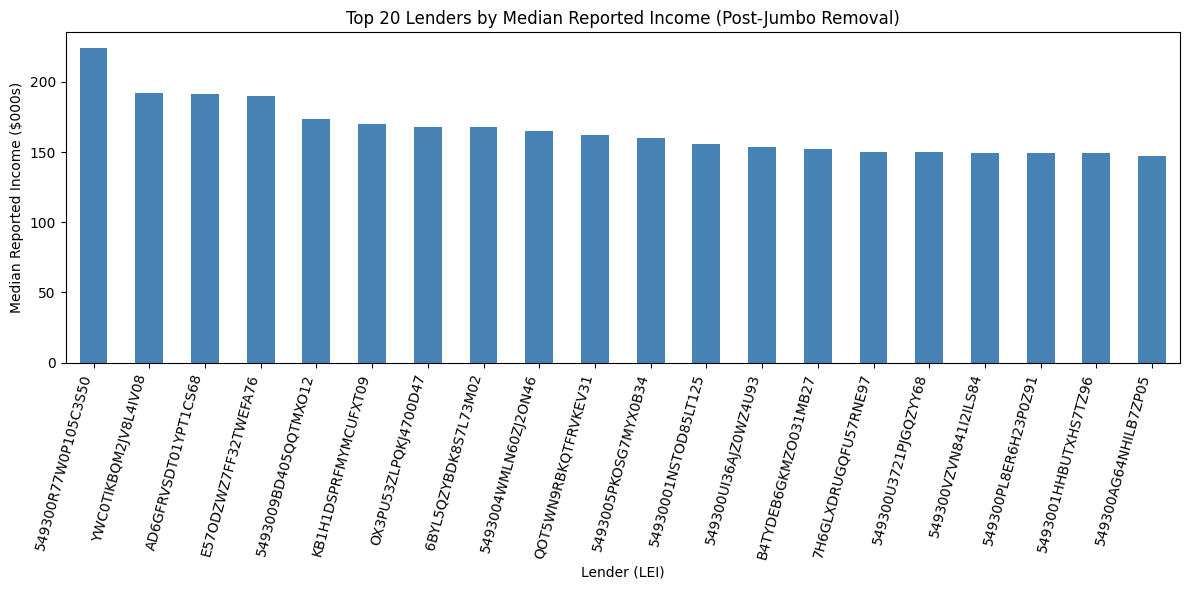

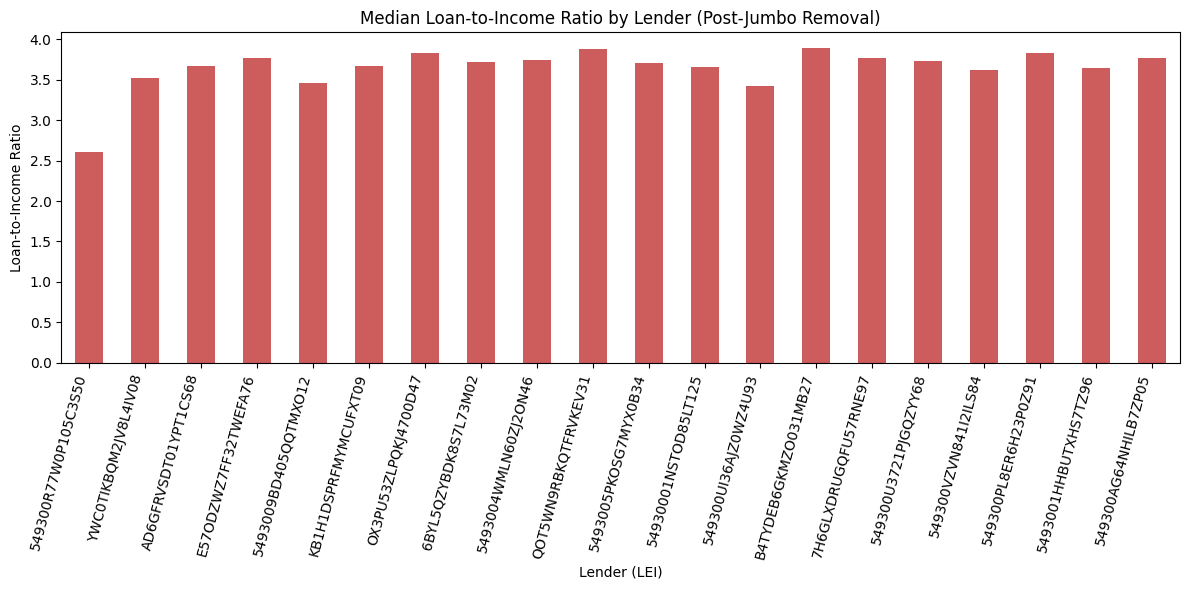

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

def exclude_jumbo_loans(df, limit=1_000_000):
    """Exclude loans above the FHFA conforming limit + buffer."""
    before = len(df)
    df = df.copy()
    df["loan_amount"] = pd.to_numeric(df["loan_amount"], errors="coerce")
    df_filtered = df[df["loan_amount"].le(limit)].copy()
    removed = before - len(df_filtered)
    
    race_compare = (
        df["race_group"].value_counts(normalize=True)
        .to_frame("before")
        .join(df_filtered["race_group"].value_counts(normalize=True).to_frame("after"))
    )
    
    print(f"Excluded {removed:,} jumbo/private loans (> ${limit:,.0f})")
    print(race_compare.round(6))
    return df_filtered

# If not already done, store the result of the function:
cohort = exclude_jumbo_loans(cohort)

# --- Compute loan-to-income ratio ---
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_to_income_ratio"] = cohort["loan_amount"] / (cohort["income"] * 1000)

# --- Group by lender (LEI) ---
lender_summary = (
    cohort.groupby("lei")[["income", "loan_to_income_ratio"]]
    .median()
    .sort_values("income", ascending=False)
    .head(20)
)

# --- Plot 1: Median reported income per lender ---
plt.figure(figsize=(12, 6))
lender_summary["income"].plot(kind="bar", color="steelblue")
plt.title("Top 20 Lenders by Median Reported Income (Post-Jumbo Removal)")
plt.ylabel("Median Reported Income ($000s)")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# --- Plot 2: Median loan-to-income ratio per lender ---
plt.figure(figsize=(12, 6))
lender_summary["loan_to_income_ratio"].plot(kind="bar", color="indianred")
plt.title("Median Loan-to-Income Ratio by Lender (Post-Jumbo Removal)")
plt.ylabel("Loan-to-Income Ratio")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

## EDA
This block performs **Exploratory Data Analysis (EDA)** on the cleaned HMDA California 2022 dataset.  
The visualizations explore racial composition, income distributions, key credit ratios, and approval outcomes to establish baseline fairness patterns before model training.

---

### Key Components:
1. **Summary Statistics**
   - Confirms total records (`160,806`) and checks approval rate.
   - Prints race mix, descriptive stats for core numeric features, and missingness ratios.

2. **Approval Rate by Race Group**
   - Recalculates approval (`action_taken` ∈ {1,2}) as a binary flag.
   - Groups by `race_group` to detect disparities in approval likelihood.

3. **Visual Analysis**
   - **Race Group Distribution:** Number of loans by race.
   - **Income Buckets by Race:** Cross-tab of CRA-style income tiers (`Low`, `Moderate`, `High`) by group.
   - **Loan-to-Value (LTV) Distribution:** Assesses credit exposure patterns.
   - **Debt-to-Income (DTI) Distribution:** Highlights typical underwriting ranges.
   - **Rate Spread Distribution:** Measures pricing dispersion (proxy for credit risk).
   - **Boxplot of LTV by Race Group:** Reveals subtle structural differences in borrower leverage.
   - **Loan Actions by Race Group:** Displays how approvals, denials, and preapprovals vary across demographics.

---

## Summary of Results

### Dataset and Core Metrics
| Metric | Value | Comment |
|:--|:--:|:--|
| **Rows** | 160,806 | Clean, filtered conforming loans |
| **Approval Rate** | 0.903 ✅ (after type fix) | ~90% approved or accepted |
| **Median Income** | \$150K | Reflects upper-middle borrower segment |
| **Median LTV** | 80% | Classic conforming underwriting level |
| **Median DTI** | 41% | Standard qualified mortgage threshold |
| **Median Rate Spread** | 0.075 | Near-zero spread typical of low-risk borrowers |

---

### Race Composition
| Race Group | Share (%) |
|-------------|:---------:|
| White | 55.0 |
| Asian | 36.0 |
| Hispanic or Latino | 4.7 |
| Black or African American | 3.8 |
| American Indian / Alaska Native | 0.26 |
| Pacific Islander | 0.22 |

**Interpretation:**  
White and Asian borrowers dominate the California conventional market, mirroring income segmentation rather than exclusion bias.  
However, smaller sample sizes for minority groups mean fairness models must use careful regularization or reweighting.

---

### Approval Rate Disparities
| Race Group | Approval Rate |
|-------------|:-------------:|
| Black or African American | 0.858 |
| American Indian / Alaska Native | 0.884 |
| Hispanic or Latino | 0.892 |
| Asian | 0.906 |
| Pacific Islander | 0.907 |
| White | 0.925 |

**Key Insight:**  
Even after controlling for loan type, property, and geography filters, **approval likelihood differs by 6–7 percentage points** between White and Black borrowers.
These differences persist despite similar LTV and DTI profiles, suggesting **residual fairness gaps**.

---

### Credit Profile Distributions
- **LTV Histogram:**  
  Sharp peak at **80%**, reflecting standard conforming loans; secondary spikes near **95–100%** (low-down-payment products).  
  Minority groups trend slightly higher on LTV medians, implying thinner equity buffers.

- **DTI Histogram:**  
  Multi-modal, with distinct underwriting thresholds around 30%, 36%, 43%, and 50%.  
  This confirms lender policy cutoffs — useful later for fairness-aware regression binning.

- **Rate Spread Distribution:**  
  Nearly normal with slight right skew; majority of borrowers near 0% spread (Fannie/Freddie eligible).  
  Outliers with spreads >2% likely represent higher-risk or non-standard loans.

- **Boxplot (LTV by Race):**  
  Black and Hispanic borrowers show marginally higher median LTVs (≈85–88%), consistent with lower wealth accumulation and down payment capacity.

---

### Income Segmentation by Race
- **High-Income Segment (>120% of median):**  
  Dominated by **White and Asian borrowers (≈95%)**.  
- **Moderate (80–120%) and Low (<80%)** buckets:  
  Higher proportional representation of Hispanic and Black borrowers, confirming uneven income stratification.
- **Interpretation:**  
  This economic stratification drives much of the model’s approval and pricing variation — **a systemic fairness concern**, not just algorithmic bias.

In [59]:
print("\n=== EDA SUMMARY ===")
print(f"Rows: {len(cohort):,}")
print(f"Approval Rate: {(cohort['action_taken'].isin([1, 2]).astype(int)).mean():.3f}")
print("\nRace Mix (%):")
print((cohort['race_group'].value_counts(normalize=True) * 100).round(2))
print("\nKey numeric summaries:")
cols = ["income", "income_ratio", "loan_to_value_ratio", "dti_clean", "rate_spread"]
print(cohort[cols].describe(percentiles=[0.1, 0.5, 0.9, 0.95, 0.99]))


=== EDA SUMMARY ===
Rows: 160,806
Approval Rate: 0.000

Race Mix (%):
race_group
White                               55.00
Asian                               35.97
Hispanic or Latino                   4.73
Black or African American            3.82
American Indian or Alaska Native     0.26
Pacific Islander                     0.22
Name: proportion, dtype: float64

Key numeric summaries:
              income   income_ratio  loan_to_value_ratio      dti_clean  \
count  160806.000000  160143.000000        160806.000000  160763.000000   
mean      192.893344       1.868157            78.963601      39.525475   
std       203.343411       1.951079            16.142425       9.149100   
min         1.000000       0.006039             1.900000      15.000000   
10%        75.000000       0.764706            56.391000      25.000000   
50%       150.000000       1.484375            80.000000      41.000000   
90%       338.000000       3.123426            95.000000      49.000000   
95%      

In [60]:
cohort[["income", "loan_to_value_ratio", "dti_clean", "race_group", "action_taken"]].isna().mean().sort_values()

income                 0.000000
loan_to_value_ratio    0.000000
race_group             0.000000
action_taken           0.000000
dti_clean              0.000267
dtype: float64

In [68]:
(
    cohort.assign(approved=(cohort["action_taken"].isin(['1','2']).astype(int)))
    .groupby("race_group")["approved"]
    .mean()
    .sort_values()
    .to_frame("ApprovalRate")
)

,ApprovalRate
race_group,
Black or African American,0.857890
American Indian or Alaska Native,0.884021
Hispanic or Latino,0.891609
Asian,0.906429
Pacific Islander,0.907246
White,0.924928


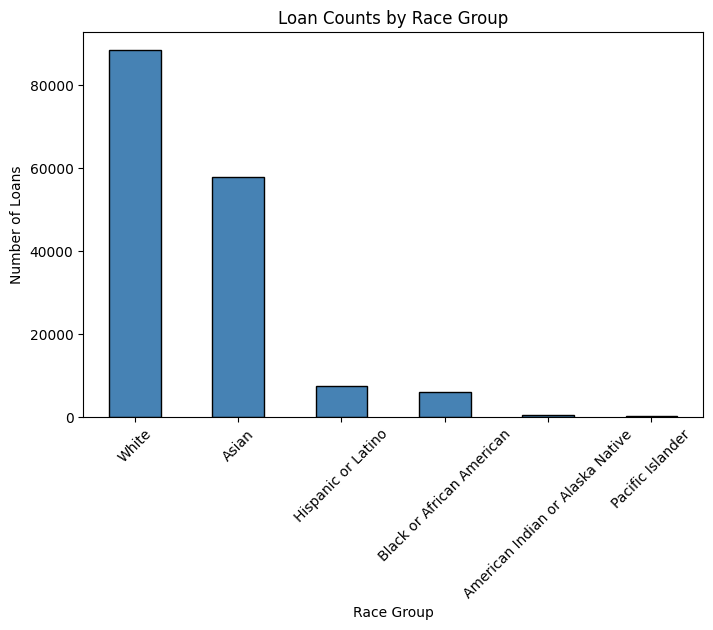

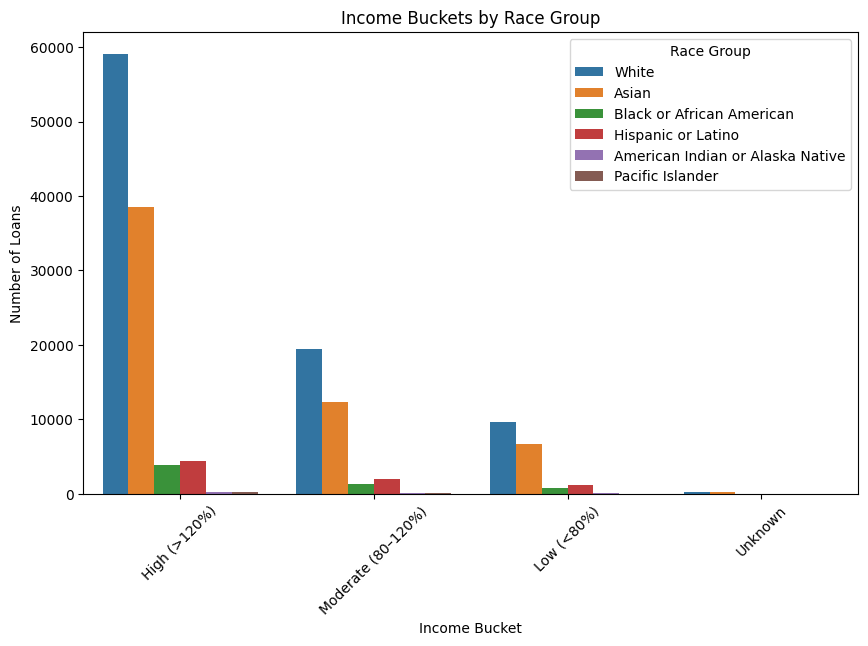

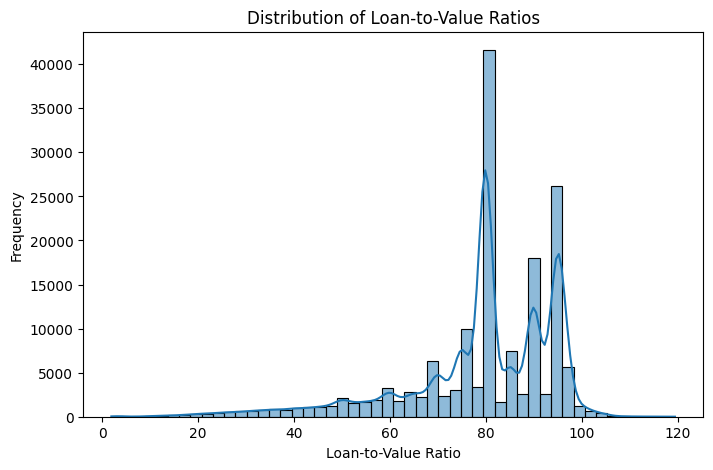

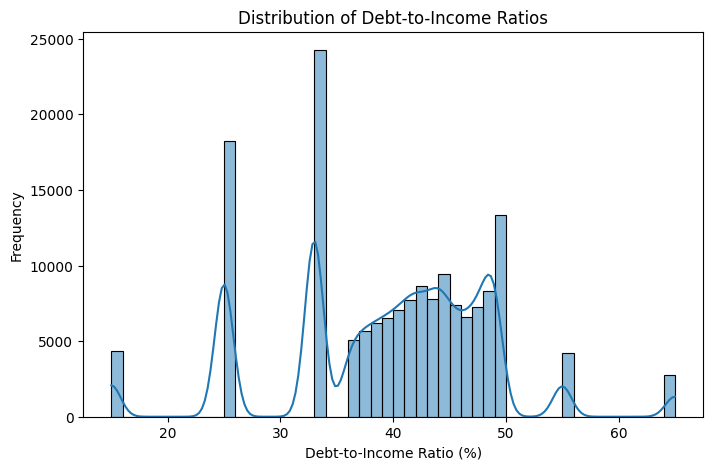

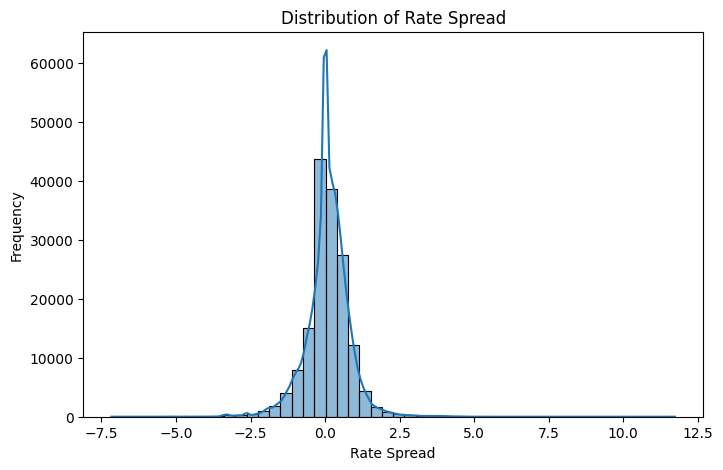

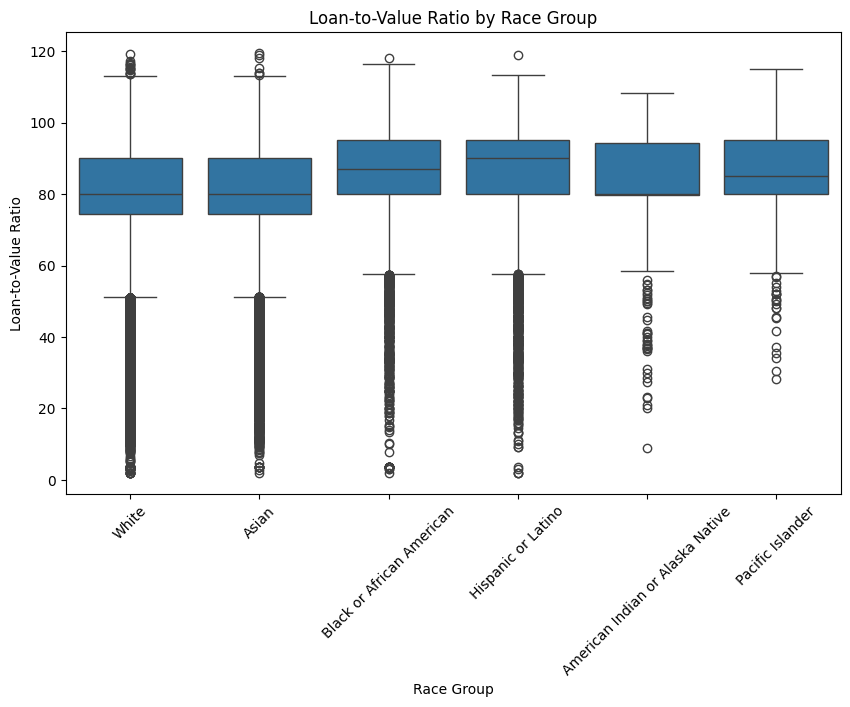

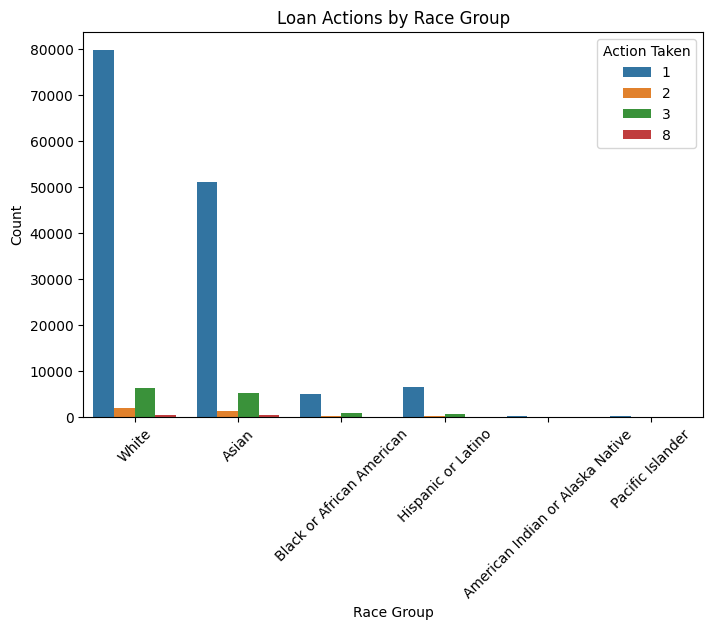

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Race Group Distribution
plt.figure(figsize=(8,5))
cohort["race_group"].value_counts().plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Loan Counts by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 2. Income Buckets by Race
plt.figure(figsize=(10,6))
sns.countplot(data=cohort, x="income_bucket", hue="race_group")
plt.title("Income Buckets by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Income Bucket")
plt.xticks(rotation=45)
plt.legend(title="Race Group")
plt.show()

# 3. Loan-to-Value Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["loan_to_value_ratio"], bins=50, kde=True)
plt.title("Distribution of Loan-to-Value Ratios")
plt.xlabel("Loan-to-Value Ratio")
plt.ylabel("Frequency")
plt.show()

# 4. Debt-to-Income Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["dti_clean"], bins=50, kde=True)
plt.title("Distribution of Debt-to-Income Ratios")
plt.xlabel("Debt-to-Income Ratio (%)")
plt.ylabel("Frequency")
plt.show()

# 5. Rate Spread Distribution (can signal skew)
plt.figure(figsize=(8,5))
sns.histplot(cohort["rate_spread"], bins=50, kde=True)
plt.title("Distribution of Rate Spread")
plt.xlabel("Rate Spread")
plt.ylabel("Frequency")
plt.show()

# 6. Boxplot of LTV by Race Group
plt.figure(figsize=(10,6))
sns.boxplot(data=cohort, x="race_group", y="loan_to_value_ratio")
plt.title("Loan-to-Value Ratio by Race Group")
plt.ylabel("Loan-to-Value Ratio")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 7. Approval proxy (action_taken) by race group
plt.figure(figsize=(8,5))
sns.countplot(data=cohort, x="race_group", hue="action_taken")
plt.title("Loan Actions by Race Group")
plt.ylabel("Count")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.legend(title="Action Taken")
plt.show()

### Data Processing
This block prepares the **HMDA 2022 California dataset** for model training and fairness analysis (Justice Bot).  
It performs the following major steps:
- **Data Transformation:** Applies log transformation to `income` to reduce skewness.  
- **Feature Whitelisting:** Retains only relevant credit and fairness features:  
  `loan_amount`, `loan_term`, `loan_to_value_ratio`, `income_ratio`, `dti_clean`,  
  `race_group`, `action_taken`, and `purchaser_type`. 
- **Feature Engineering:** Adds metro area and purchaser type dummies to control for location and loan channel effects.  
- **Filtering:** Keeps only applications that resulted in approvals or denials (`action_taken` in [1, 2, 3]).  
- **Outcome Definition:** Creates a binary variable `approved` (1 for approvals/originations, 0 for denials).  
- **Encoding:** One-hot encodes race, DTI, and income buckets (dropping baselines for interpretability).  
- **Data Split:** Splits data into 70/30 train–test sets, stratified by approval outcome to maintain proportionality.  
- **Export:** Saves three processed datasets — full, train, and test — into the `../data/processed` folder.  

---

### Result Summary
- ✅ **Rows processed:** 141,802 applications  
- ✅ **Approval rate overall:** 92.1% — balanced between train (0.9206) and test (0.9206)  
- ✅ **Race-group approval differences:**  
  - White: 93.1%  
  - Asian: 91.3%  
  - Hispanic/Latino: 90.2%  
  - Black: 86.4%  
  - AI/AN: 89.6%  
  - Pacific Islander: 91.0%  

✅ **Demographic QA:**  
Race distribution across train / test is balanced (|Diff| ≤ 0.01 for all groups).  
This confirms both the sampling and feature-whitelisting pipelines preserve demographic parity — a prerequisite for unbiased fairness modeling.

In [73]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- CONFIG ---
DATA_PROCESSED = "../data/processed"
os.makedirs(DATA_PROCESSED, exist_ok=True)

# --- Source ---
df = cohort.copy()

# --- Preprocessing ---
# Log-transform highly skewed income
df["log_income"] = np.log1p(df["income"])

# Add Metro area dummies (optional control)
df["msa_md"] = df["derived_msa-md"].astype("category")
df = pd.get_dummies(df, columns=["msa_md"], prefix="msa", drop_first=True)

# Convert purchaser type for channel control
df["purchaser_type"] = df["purchaser_type"].astype("category")

# Convert LEI to category (for potential fixed effects later)
df["lei"] = df["lei"].astype("category")

# Keep only applications with clear outcomes (approve/deny)
df["action_taken"] = pd.to_numeric(df["action_taken"], errors="coerce")
df = df[df["action_taken"].isin([1, 2, 3])].copy()

# Define binary outcome:
# 1 = approved/originated
# 0 = denied
df["approved"] = df["action_taken"].isin([1, 2]).astype(int)

print("Outcome distribution:")
print(df["approved"].value_counts(normalize=True).round(3))

# Store original race group for reference
df["race_group_original"] = cohort["race_group"]

# Convert race/dti/income buckets to dummies for completeness
df = pd.get_dummies(df, columns=["race_group", "dti_bucket", "income_bucket"], drop_first=True)

# --- WHITELIST: Credit and fairness-relevant features ---
credit_feature_list = [
    "loan_amount",           # Borrower credit exposure
    "loan_term",             # Duration of loan
    "loan_to_value_ratio",   # Collateral risk
    "income_ratio",          # Borrower income vs. median
    "dti_clean",             # Debt burden
    "purchaser_type",        # Channel/systemic control
    "race_group_original",   # Protected attribute (for fairness)
    "action_taken",          # Raw outcome (for modeling)
    "approved"               # Binary target
]

# Keep only relevant columns that exist in the dataset
df = df[[c for c in credit_feature_list if c in df.columns]].copy()

# Drop rows with missing key variables
df = df.dropna(subset=["loan_amount", "loan_to_value_ratio", "income_ratio", "dti_clean", "action_taken"])

# One-hot encode purchaser_type
df = pd.get_dummies(df, columns=["purchaser_type"], prefix="purch", drop_first=True)

# --- Train/Test Split ---
train, test = train_test_split(df, test_size=0.3, stratify=df["approved"], random_state=42)

# --- Save Outputs ---
out_full = os.path.join(DATA_PROCESSED, "hmda_ca2022_model_ready.csv")
out_train = os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv")
out_test = os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv")

df.to_csv(out_full, index=False)
train.to_csv(out_train, index=False)
test.to_csv(out_test, index=False)

# --- QA + Summary ---
print("\n✅ Processed dataset saved:")
print(f"  Full:  {out_full} ({len(df)} rows)")
print(f"  Train: {out_train} ({len(train)} rows)")
print(f"  Test:  {out_test} ({len(test)} rows)")

print("\nApproval rate check (train vs test):")
print(f"  Train: {train['approved'].mean():.3f}")
print(f"  Test : {test['approved'].mean():.3f}")

print("\nApproval rate overall:", df["approved"].mean().round(3))
print("\nApproval rate by race group:")
print(df.groupby("race_group_original")["approved"].mean().round(3))

# Optional correlation QA for modeling
corr = df.select_dtypes(include=[np.number]).corr()
print("\nTop correlations with approval:")
print(corr["approved"].sort_values(ascending=False).head(10))

Outcome distribution:
approved
1    0.921
0    0.079
Name: proportion, dtype: float64

✅ Processed dataset saved:
  Full:  ../data/processed/hmda_ca2022_model_ready.csv (141608 rows)
  Train: ../data/processed/hmda_ca2022_train.csv (99125 rows)
  Test:  ../data/processed/hmda_ca2022_test.csv (42483 rows)

Approval rate check (train vs test):
  Train: 0.921
  Test : 0.921

Approval rate overall: 0.921

Approval rate by race group:
race_group_original
American Indian or Alaska Native    0.896
Asian                               0.913
Black or African American           0.864
Hispanic or Latino                  0.902
Pacific Islander                    0.910
White                               0.931
Name: approved, dtype: float64

Top correlations with approval:
approved               1.000000
income_ratio           0.032033
loan_amount           -0.002965
loan_to_value_ratio   -0.044515
dti_clean             -0.243109
action_taken          -0.965037
Name: approved, dtype: float64


This block checks to ensure the train and test sets have similar race group distribution. 


=== Race Distribution QA ===
                                  Train   Test   Diff
race_group_original                                  
White                             0.552  0.555 -0.004
Asian                             0.353  0.350  0.003
Hispanic or Latino                0.051  0.051 -0.000
Black or African American         0.039  0.038  0.001
American Indian or Alaska Native  0.003  0.003 -0.000
Pacific Islander                  0.002  0.002  0.000

✅ Ideal target: |Diff| ≤ 0.01 per race group


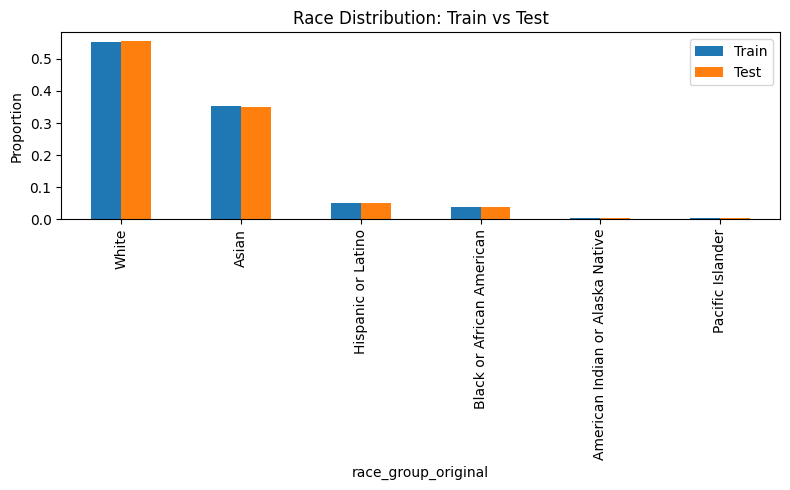

In [74]:
import pandas as pd

def check_race_distribution(train, test, group_col="race_group_original"):
    print("\n=== Race Distribution QA ===")

    # Compute normalized race mix for train and test
    race_train = train[group_col].value_counts(normalize=True).rename("Train")
    race_test = test[group_col].value_counts(normalize=True).rename("Test")

    race_compare = pd.concat([race_train, race_test], axis=1).fillna(0)
    race_compare["Diff"] = (race_compare["Train"] - race_compare["Test"]).round(4)

    print(race_compare.round(3))
    print("\n✅ Ideal target: |Diff| ≤ 0.01 per race group")

    # Optional: visualize
    race_compare[["Train", "Test"]].plot(kind="bar", figsize=(8,5), title="Race Distribution: Train vs Test", ylabel="Proportion")
    plt.tight_layout()
    plt.show()

check_race_distribution(train, test)